# Simple Variational AutoEncoder training and inference example

**Description**: in this notebook, we showcase the training process and inference capabilities of a simple variational auto-encoder model.

## Imports, definitions and setup

The first block is needed only when the current environment doesn't have the `dlproject` package installed.
Therefore, if you already cloned the whole repository and run the `pip install -e .` command, you can skip the first block.

If you're running this notebook only on a Jupyter server, run the first block as well in order to obtain the necessary dependencies.

In [ ]:
!git clone https://github.com/peiva-git/deep_learning_project.git
%cd deep_learning_project
!pip install -e .

In [1]:
import dlproject as dlp
import tensorflow as tf

import os.path

2023-11-07 11:10:43.268023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 11:10:43.268074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 11:10:43.272157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 11:10:43.590898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the MNIST dataset

In [2]:
dataset_builder = dlp.data.MNISTDatasetBuilder()
dataset_builder.preprocess_dataset_simple_vae()
train_x, test_x = dataset_builder.train_x, dataset_builder.test_x
train_y, test_y = dataset_builder.train_y, dataset_builder.test_y

## Instantiate the model

First we define the layers:

In [3]:
from keras import backend as be

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = tf.keras.layers.Input(shape=(original_dim,))
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = be.random_normal(shape=(be.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + be.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

# Encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='vae_encoder')

# Decoder
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='vae_decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')


2023-11-07 11:10:57.100596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 11:10:57.167758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 11:10:57.168443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

And then we define a custom loss function:

In [4]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - be.square(z_mean) - be.exp(z_log_sigma)
kl_loss = be.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = be.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

## Train the model

Train the instantiated model on the MNIST dataset.

This block also saves a backup and a checkpoint every 20 epochs, so that you can automatically resume the training if it gets interrupted.

In [5]:
if not os.path.exists(os.path.join(os.getcwd(), 'output', 'training-callback-results', f'{vae.name}_mnist')):
    os.makedirs(os.path.join(os.getcwd(), 'output', 'training-callback-results', f'{vae.name}_mnist', 'backup'))
    os.makedirs(os.path.join(os.getcwd(), 'output', 'training-callback-results', f'{vae.name}_mnist', 'model_checkpoints'))

model_dir_path = os.path.join(os.getcwd(), 'output', 'training-callback-results', f'{vae.name}_mnist')

vae.fit(
    train_x, train_x,
    epochs=100,
    batch_size=32,
    validation_data=(test_x, test_x),
    callbacks=[
        tf.keras.callbacks.BackupAndRestore(
            backup_dir=os.path.join(model_dir_path, 'backup'),
            save_freq=37500 # 20 * 1875, each 20 epochs
        ),
        tf.keras.callbacks.ModelCheckpoint(model_dir_path, 'model_checkpoints', save_freq=37500)
    ]
)

Epoch 1/100


2023-11-07 11:11:20.515968: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 11:11:21.033242: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe3a425e690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 11:11:21.033313: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-11-07 11:11:21.054397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 11:11:21.101187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-07 11:11:21.193070: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 9s 4ms/step - loss: 188.3562 - val_loss: 168.2944
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 165.9469 - val_loss: 164.2772
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 162.5454 - val_loss: 161.9513
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 160.2544 - val_loss: 159.8043
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 158.5002 - val_loss: 158.0379
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 157.0711 - val_loss: 157.0127
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.9156 - val_loss: 155.6308
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 154.9829 - val_loss: 155.0600
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 154.2330 - val_loss: 154.2975
Epoch 10/100
1875/1875 [=========================

INFO:tensorflow:Assets written to: /home/peiva/PycharmProjects/deep_learning_project/output/training-callback-results/vae_mlp_mnist/assets


1875/1875 [==============================] - 7s 4ms/step - loss: 149.8653 - val_loss: 150.4138
Epoch 21/100
1875/1875 [==============================] - 6s 3ms/step - loss: 149.6347 - val_loss: 150.3507
Epoch 22/100
1875/1875 [==============================] - 6s 3ms/step - loss: 149.4046 - val_loss: 150.2326
Epoch 23/100
1875/1875 [==============================] - 6s 3ms/step - loss: 149.1910 - val_loss: 149.8550
Epoch 24/100
1875/1875 [==============================] - 7s 4ms/step - loss: 148.9597 - val_loss: 149.6826
Epoch 25/100
1875/1875 [==============================] - 6s 3ms/step - loss: 148.7989 - val_loss: 149.4541
Epoch 26/100
1875/1875 [==============================] - 6s 3ms/step - loss: 148.6365 - val_loss: 149.3056
Epoch 27/100
1875/1875 [==============================] - 6s 3ms/step - loss: 148.4441 - val_loss: 149.0152
Epoch 28/100
1875/1875 [==============================] - 6s 3ms/step - loss: 148.2919 - val_loss: 149.0207
Epoch 29/100
1875/1875 [=================

INFO:tensorflow:Assets written to: /home/peiva/PycharmProjects/deep_learning_project/output/training-callback-results/vae_mlp_mnist/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 146.9048 - val_loss: 148.1397
Epoch 41/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.8345 - val_loss: 148.1501
Epoch 42/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.7336 - val_loss: 147.7848
Epoch 43/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.6467 - val_loss: 147.5435
Epoch 44/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.5788 - val_loss: 147.8878
Epoch 45/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.4942 - val_loss: 147.5097
Epoch 46/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.4233 - val_loss: 147.6357
Epoch 47/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.3367 - val_loss: 147.5111
Epoch 48/100
1875/1875 [==============================] - 6s 3ms/step - loss: 146.2941 - val_loss: 147.4824
Epoch 49/100
1875/1875 [=================

INFO:tensorflow:Assets written to: /home/peiva/PycharmProjects/deep_learning_project/output/training-callback-results/vae_mlp_mnist/assets


1875/1875 [==============================] - 7s 3ms/step - loss: 145.5694 - val_loss: 146.9719
Epoch 61/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.5226 - val_loss: 146.9582
Epoch 62/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.4502 - val_loss: 146.9303
Epoch 63/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.4194 - val_loss: 146.9082
Epoch 64/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.3665 - val_loss: 147.1295
Epoch 65/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.3285 - val_loss: 146.9585
Epoch 66/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.2623 - val_loss: 146.9796
Epoch 67/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.2490 - val_loss: 147.2137
Epoch 68/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.1744 - val_loss: 147.0394
Epoch 69/100
1875/1875 [=================

INFO:tensorflow:Assets written to: /home/peiva/PycharmProjects/deep_learning_project/output/training-callback-results/vae_mlp_mnist/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 144.7421 - val_loss: 146.3982
Epoch 81/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.6852 - val_loss: 146.3960
Epoch 82/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.6427 - val_loss: 146.3635
Epoch 83/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.6304 - val_loss: 146.2793
Epoch 84/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.5907 - val_loss: 146.3177
Epoch 85/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.5735 - val_loss: 146.6479
Epoch 86/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.5326 - val_loss: 146.5533
Epoch 87/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.4834 - val_loss: 146.5749
Epoch 88/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.4643 - val_loss: 146.2345
Epoch 89/100
1875/1875 [=================

INFO:tensorflow:Assets written to: /home/peiva/PycharmProjects/deep_learning_project/output/training-callback-results/vae_mlp_mnist/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 144.1306 - val_loss: 146.1444


## Save the trained model

Save the just trained model for later use.

In [6]:
if not os.path.exists(os.path.join(os.getcwd(), 'output', 'models')):
    os.makedirs(os.path.join(os.getcwd(), 'output', 'models'))

vae.save(os.path.join(os.getcwd(), 'output', 'models', f'{vae.name}_mnist.keras'))
encoder.save(os.path.join(os.getcwd(), 'output', 'models', f'{encoder.name}_mnist.keras'))
decoder.save(os.path.join(os.getcwd(), 'output', 'models', f'{decoder.name}_mnist.keras'))

## Load the model

Instead of training the model, you can load it from a previously saved `.keras` file.

In [8]:
vae_model = tf.keras.saving.load_model(os.path.join(os.getcwd(), 'output', 'models', 'vae_mlp_mnist.keras'), safe_mode=False)
vae_encoder = tf.keras.saving.load_model(os.path.join(os.getcwd(), 'output', 'models', 'vae_encoder_mnist.keras'), safe_mode=False)
vae_decoder = tf.keras.saving.load_model(os.path.join(os.getcwd(), 'output', 'models', 'vae_decoder_mnist.keras'), safe_mode=False)

ValueError: Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['dense/kernel:0', 'dense/bias:0']

## Visualization

Display a scatter plot of the encoded test data.

313/313 [==============================] - 0s 1ms/step


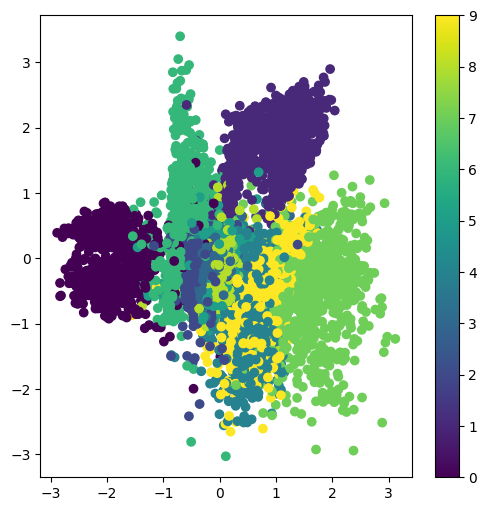

In [19]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(test_x)[2]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=test_y)
plt.colorbar()
plt.show()

Display artificially generated digits.

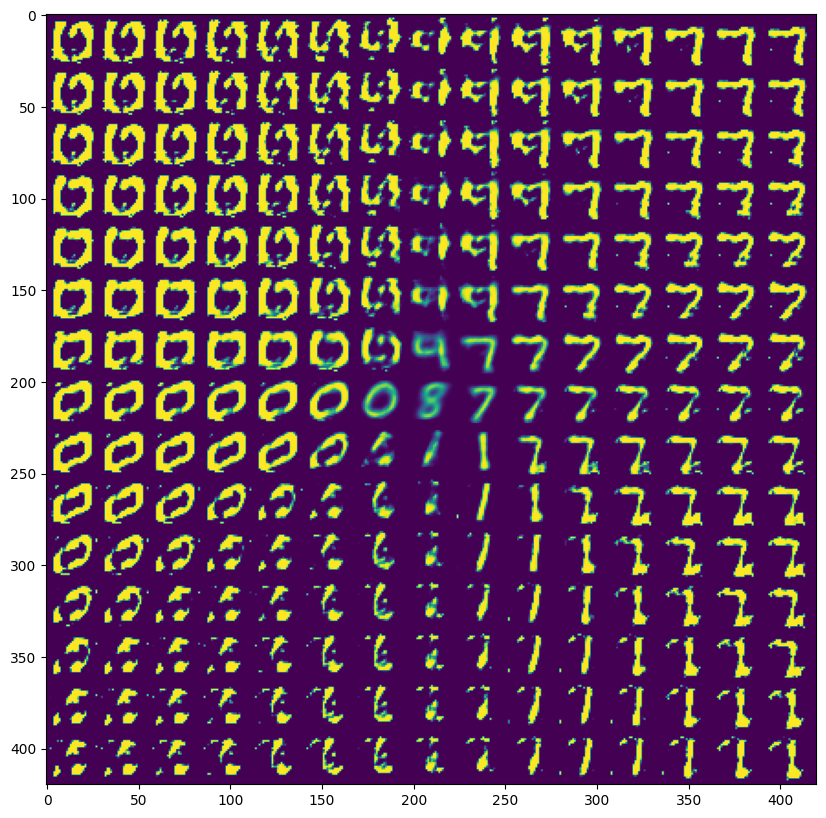

In [23]:
import numpy as np

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder(z_sample)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()